In [1]:
import pandas as pd
import numpy as np


df = pd.read_excel("jester-data-1.xls", header=None)
ratings = df.iloc[:, 1:].replace(99, np.nan).to_numpy()

In [2]:
from scipy.sparse import csr_matrix

# Replace 99 with np.nan 
ratings = df.iloc[:, 1:].replace(99, np.nan).to_numpy()

# Create sparse matrix from observed entries
R_obs = csr_matrix(np.nan_to_num(ratings, nan=0.0))
mask = ~np.isnan(ratings)  # Mask of observed entries


In [3]:
def generate_initial_X_AW(shape, delta):
    m, n = shape
    u = np.random.randn(m)
    v = np.random.randn(n)
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    return -delta * np.outer(u, v)

delta = 16_000  
np.random.seed(42)

In [4]:
%reload_ext autoreload
%autoreload 2

from algorithms import FW, FWAwayStepInFace, FWPairwiseInFace

experiments = [
    {
        "name": "FW + fixed lr",
        "optimizer": FW(
            generate_initial_X_AW(R_obs.shape, delta).copy(),
            R_obs,
            delta=delta,
            lr_strategy="fixed"
        ),
    },
    {
        "name": "FW + line-search",
        "optimizer": FW(
            generate_initial_X_AW(R_obs.shape, delta).copy(),
            R_obs,
            delta=delta,
            lr_strategy="line-search"
        ),
    },
    {
        "name": "Away step FW (InFace) + line-search",
        "optimizer": FWAwayStepInFace(
            generate_initial_X_AW(R_obs.shape, delta).copy(),
            R_obs,
            delta=delta
        ),
    },
    {
        "name": "Pairwise FW (InFace) + line-search + 5 rank",
        "optimizer": FWPairwiseInFace(
            generate_initial_X_AW(R_obs.shape, delta).copy(),
            R_obs,
            delta=delta,
            rank=5
        ),
    },
    
]

In [5]:
%reload_ext autoreload
%autoreload 2

import time
from solver import RecommendationSolver
solver = RecommendationSolver(max_iter=4000, eps=10**(0))

for exp in experiments:
    print(f"\nRunning experiment: {exp['name']}")
    optimizer = exp["optimizer"]

    start_time = time.process_time()
    solver.fit(optimizer)
    end_time = time.process_time()

    exp["cpu_time"] = end_time - start_time

    exp["duality_gap_list"] = solver.duality_gap_list
    exp["train_error_list"] = solver.train_error_list
    exp["cpu_timings"] = solver.cpu_timings


    solver.reset()

for exp in experiments:
    print(f"{exp['name']}: CPU Time = {exp['cpu_time']:.2f}s")


Running experiment: FW + fixed lr


Converged at iteration 228 with duality gap 0.9868:   6%|▌         | 227/4000 [00:37<10:30,  5.98it/s, duality_gap=0.987, step_size=0.00873, rmse=3.24]



Running experiment: FW + line-search


Converged at iteration 188 with duality gap 0.9978:   5%|▍         | 187/4000 [00:39<13:31,  4.70it/s, duality_gap=0.998, step_size=0.00419, rmse=3.31]



Running experiment: Away step FW (InFace) + line-search


Converged at iteration 95 with duality gap 0.9791:   2%|▏         | 94/4000 [00:24<17:16,  3.77it/s, duality_gap=0.979, step_size=0.00406, step_type=FW, rmse=3.29]



Running experiment: Pairwise FW (InFace) + line-search + 5 rank


Converged at iteration 27 with duality gap 0.9480:   1%|          | 26/4000 [00:07<19:45,  3.35it/s, duality_gap=0.948, step_size=0.00209, step_type=PairwiseInFace, rmse=3.86]

FW + fixed lr: CPU Time = 355.91s
FW + line-search: CPU Time = 378.79s
Away step FW (InFace) + line-search: CPU Time = 237.45s
Pairwise FW (InFace) + line-search + 5 rank: CPU Time = 73.28s


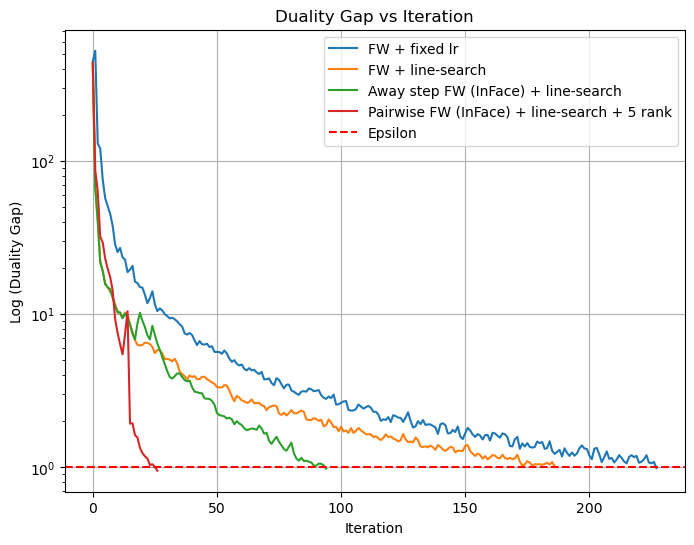

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Optional: slightly more compact
for exp in experiments:
    plt.plot(exp["duality_gap_list"], label=exp["name"])

plt.axhline(y=solver.eps, color='r', linestyle='--', label='Epsilon')

plt.xlabel('Iteration')
plt.ylabel('Log (Duality Gap)')
plt.title('Duality Gap vs Iteration')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()